# Lab 4 Report: 
## Surpass Human Performance in Fashion MNIST Classificaion

### Name:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

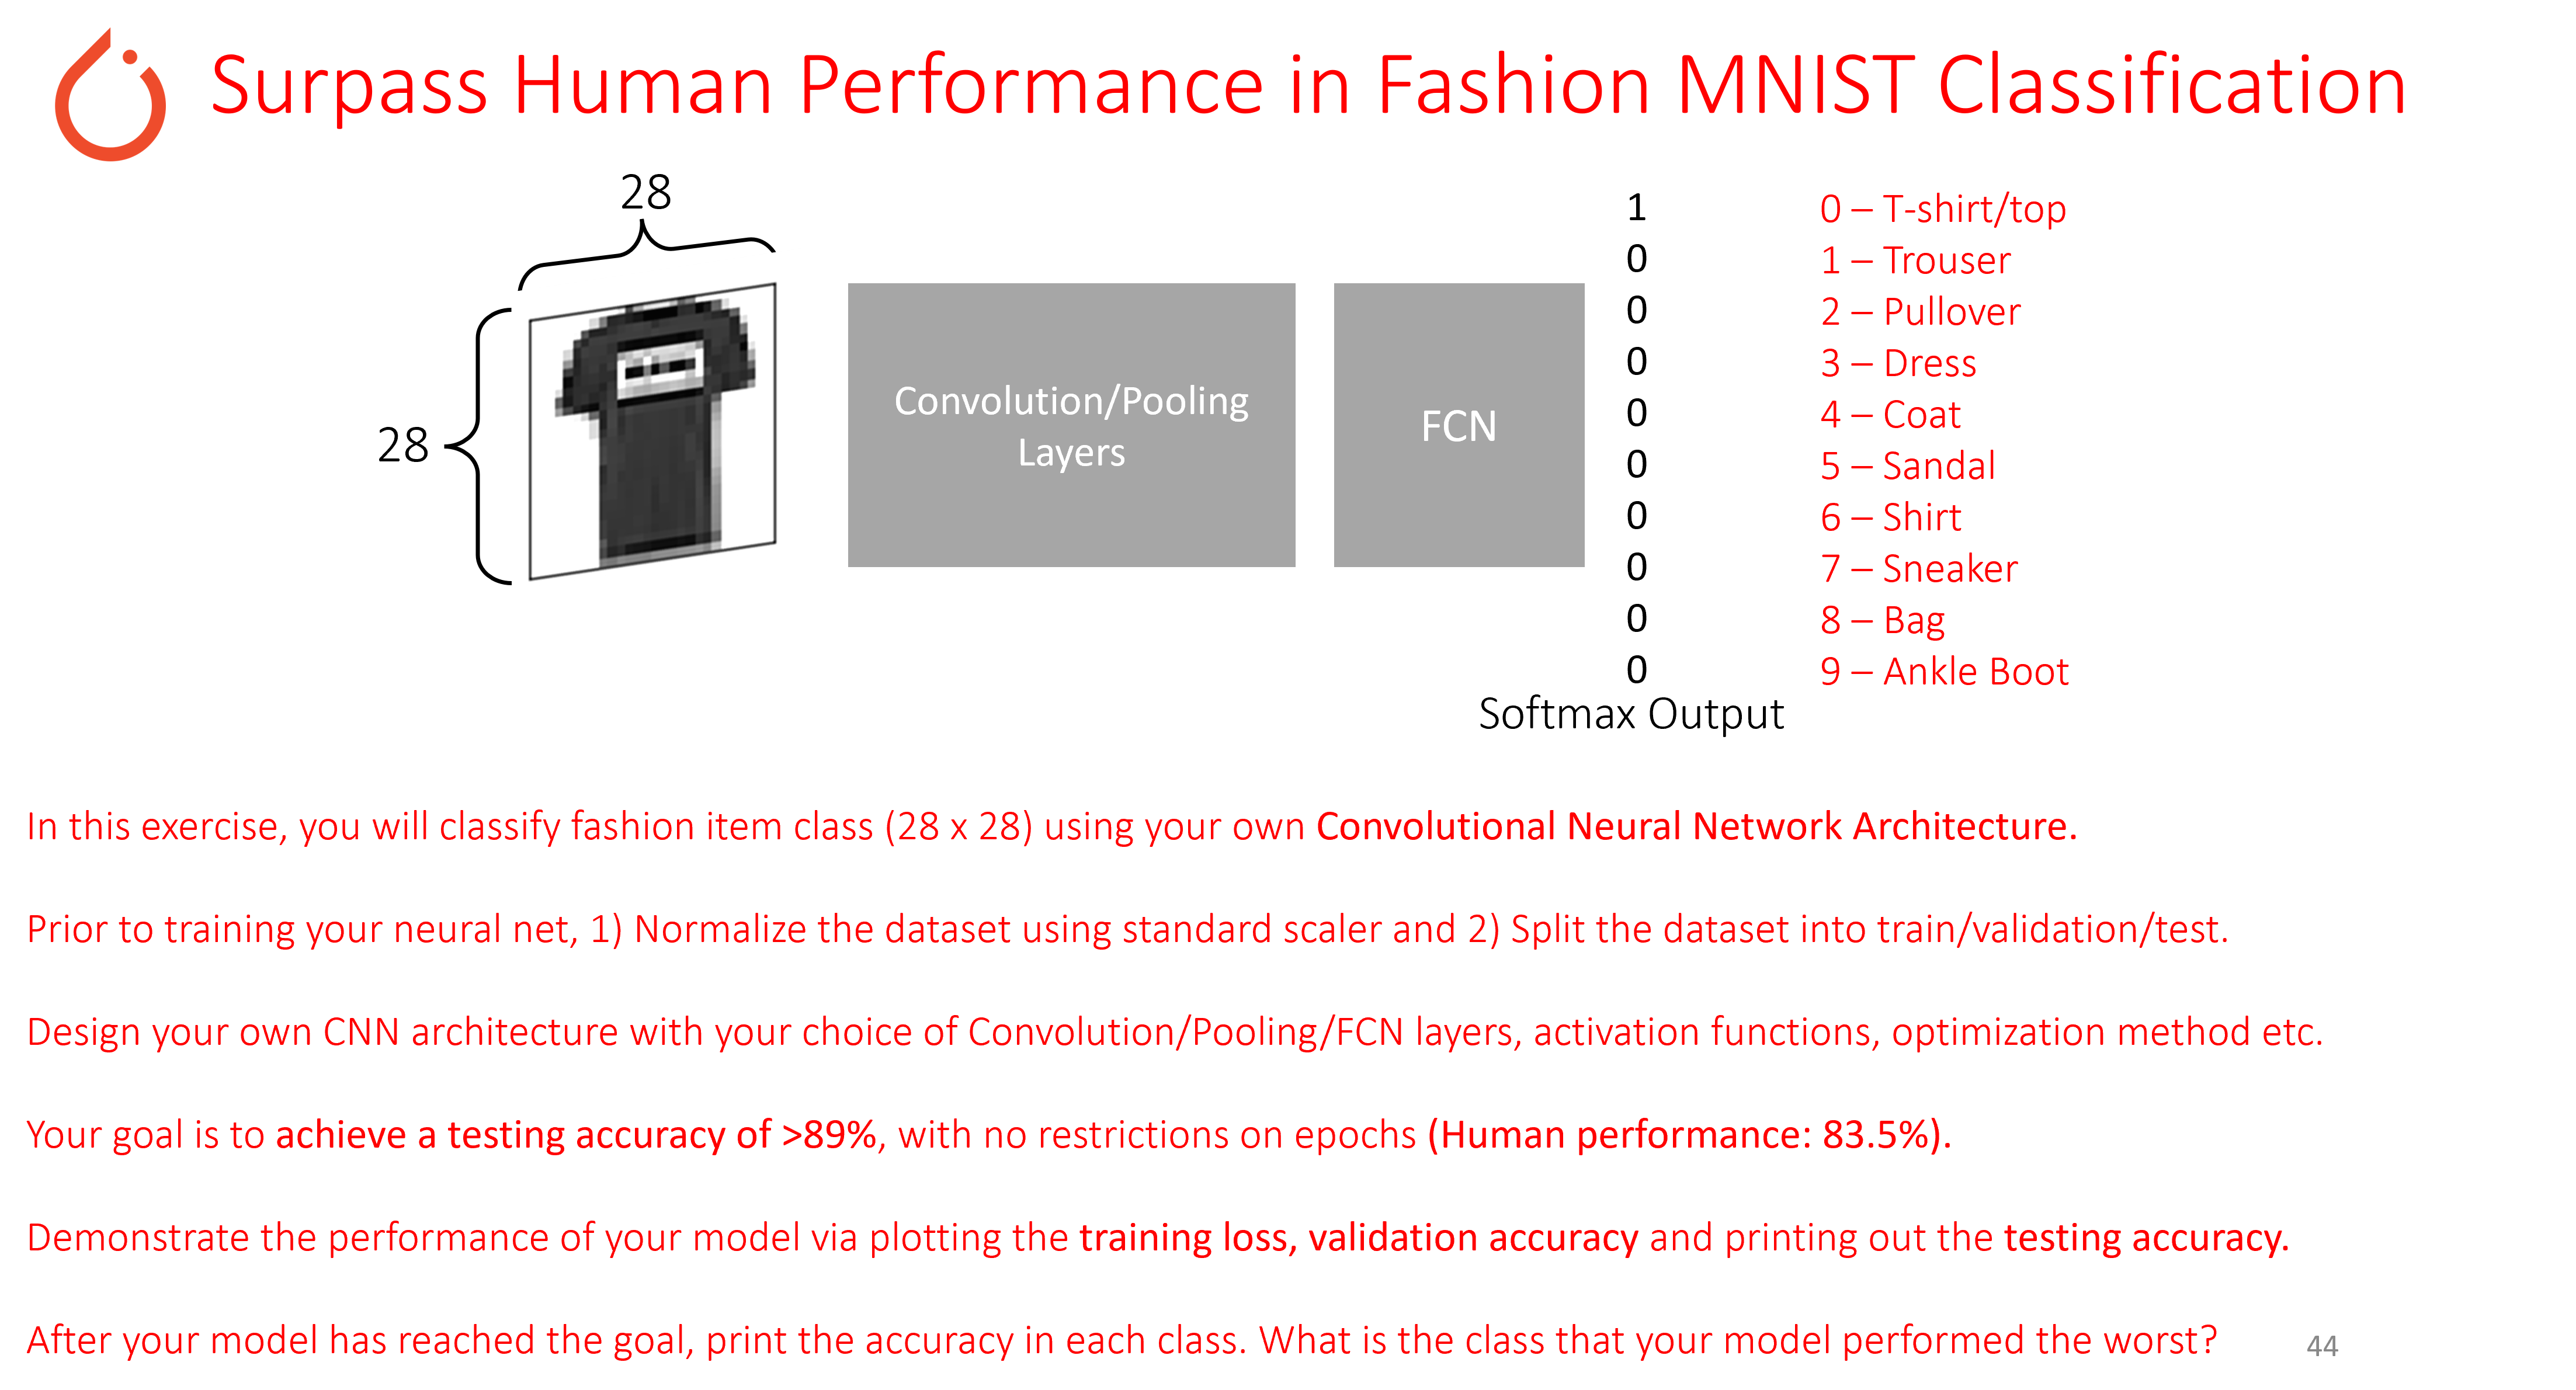

In [3]:
Image('lab4_exercise.png', width = 1000)

## Prepare Data

In [4]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy') 
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


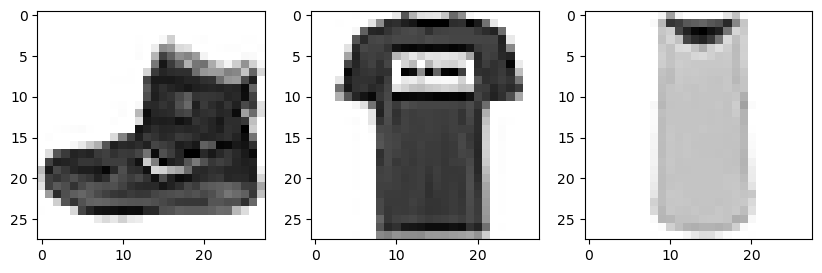

In [5]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [6]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

train_features = train_features.reshape((10000, 28 * 28))
test_features = test_features.reshape((1000, 28 * 28))

In [7]:
# Define your scaling function
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the dataset according to standard scaling
train_features = scaler.fit_transform(train_features).reshape((10000, 28, 28))
test_features = scaler.fit_transform(test_features).reshape((1000, 28, 28))

In [8]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

validation_features = train_features[:int(train_features.shape[0]*0.1)]
validation_targets = train_targets[:int(train_targets.shape[0]*0.1)]

# Take the remaining 9000 training features and targets as training set 

train_features = train_features[int(train_features.shape[0]*0.1):]
train_targets = train_targets[int(train_targets.shape[0]*0.1):]

In [9]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = np.reshape(train_features, (9000, 1, 28, 28))
validation_features = np.reshape(validation_features, (1000, 1, 28, 28))
test_features = np.reshape(test_features, (1000, 1, 28, 28))

## Define Model

In [10]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        # YOUR CODE HERE
        # First convolution layer (1 channel -> 16 channels, preserve original dimension by adding padding = 2)
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=16, 
                              kernel_size=5, stride=1, padding=2)
        
        # First max pooling layer with kernel size = 2
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
         
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.cnn2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=5, stride=1, padding=2)
        
        # Second max pooling layer with kernel size = 2
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layer that takes the flattened output of maxpool2 (32, 7 ,7) -> (1568) and output 10 classes
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10) 
    
    def forward(self, x):
        
        # YOUR CODE HERE
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput 
        # since it's incorporated within the loss function
        # input image -> conv1 -> relu -> maxpool1
        conv1_out = torch.nn.functional.relu(self.cnn1(x))       
        pool1_out = self.maxpool1(conv1_out)
        
        # maxpool1 output -> conv2 -> relu -> maxpool2
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))    
        pool2_out = self.maxpool2(conv2_out)
        
        # flatten the maxpool2 output to be used as input into FCN layer
        fcn_input = pool2_out.view(pool2_out.size(0), -1)
    
        # Use the raw output of the fully connected layer as the final output
        output = self.fc1(fcn_input)
        
        return output

## Select Hyperparameters

In [11]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.003
epochs = 20
batchsize = 600

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

## Identify Tracked Values

In [12]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = np.zeros((epochs, ))

## Train Model

In [13]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient

train_inputs = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_inputs = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()

test_inputs = torch.from_numpy(test_features).float()
test_targets = torch.from_numpy(test_targets).long()

# Use torch.split() function to split the training inputs/targets into mini-batches
# See documentation of torch.split() https://pytorch.org/docs/stable/generated/torch.split.html
train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

# Training Loop ---------------------------------------------------------------------------------------

for epoch in range(epochs):
    
    for k in range(batch_split_num):
    
        optimizer.zero_grad()
    
        train_batch_outputs = model(train_batches_features[k])

        loss = loss_func(train_batch_outputs, train_batches_targets[k])

        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

        validation_outputs = model(validation_inputs)

        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        validation_accuracy_list[epoch] = correct.mean()


Epoch: 0 Validation Accuracy: 77.3%
Epoch: 1 Validation Accuracy: 81.5%
Epoch: 2 Validation Accuracy: 85.0%
Epoch: 3 Validation Accuracy: 86.0%
Epoch: 4 Validation Accuracy: 86.4%
Epoch: 5 Validation Accuracy: 87.3%
Epoch: 6 Validation Accuracy: 87.3%
Epoch: 7 Validation Accuracy: 87.5%
Epoch: 8 Validation Accuracy: 87.8%
Epoch: 9 Validation Accuracy: 87.9%
Epoch: 10 Validation Accuracy: 88.1%
Epoch: 11 Validation Accuracy: 88.3%
Epoch: 12 Validation Accuracy: 88.5%
Epoch: 13 Validation Accuracy: 88.2%
Epoch: 14 Validation Accuracy: 88.1%
Epoch: 15 Validation Accuracy: 88.5%
Epoch: 16 Validation Accuracy: 88.5%
Epoch: 17 Validation Accuracy: 88.9%
Epoch: 18 Validation Accuracy: 88.6%
Epoch: 19 Validation Accuracy: 88.7%


## Visualize & Evaluate Model

In [14]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

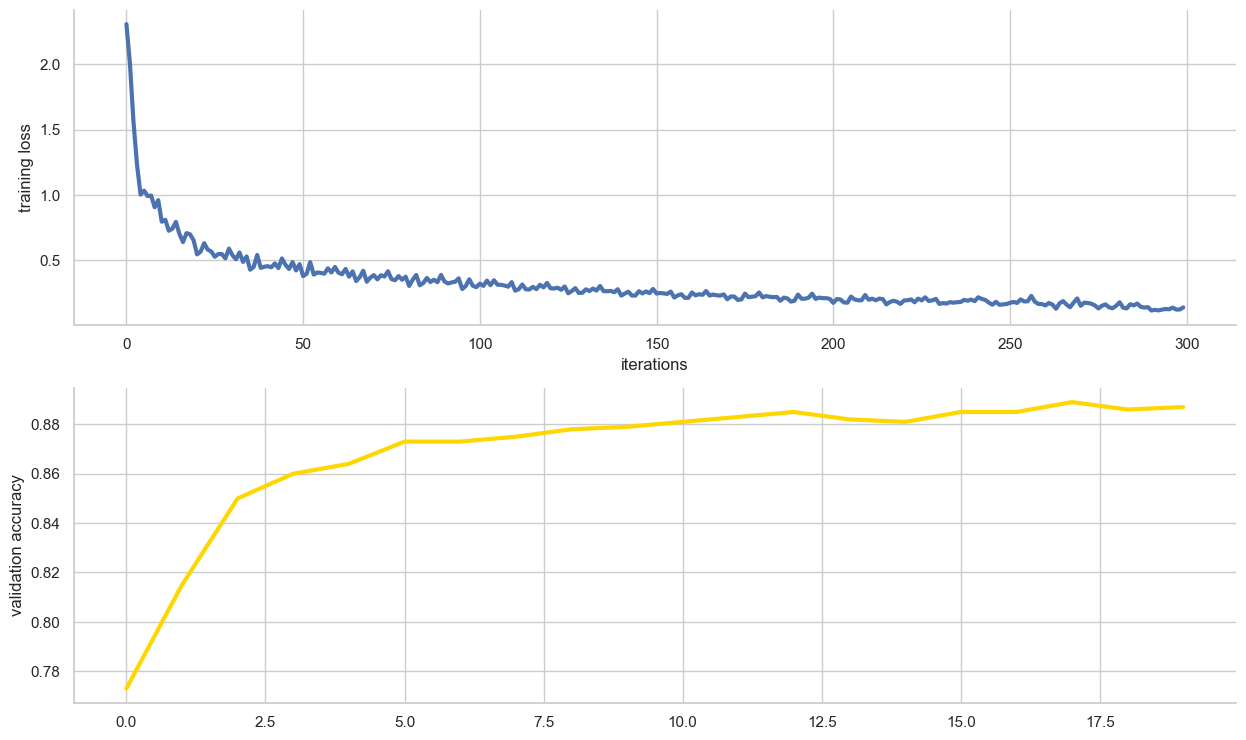

In [15]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [16]:
# Compute the testing accuracy 

test_outputs = model(test_inputs)
correct = (torch.argmax(test_outputs, dim=1) == test_targets).type(torch.FloatTensor)
print("Testing Accuracy: " + str(correct.mean().numpy()*100) + "%")

Testing Accuracy: 89.49999809265137%


In [17]:
# (OPTIONAL) Print the testing accuracy for each fashion class. Your code should produce something that looks like:
# Clever usage of np.where() could be useful here

# "Accuracy of T-shirt/top: 93.5 %"
# "Accuracy of Trouser: 89.3 %"
# etc...

# What's the fashion item that your model had the hardest time classifying?
name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
for i in range(0, 10):
    index = np.array(np.where(test_targets == i))
    sub_out = torch.argmax(test_outputs, dim=1).numpy()[index]
    correct = (sub_out == i)
    # correct = sum((torch.argmax(test_outputs, dim=1) == i).type(torch.FloatTensor))
    # type_total = sum(test_targets == i)
    accuracy = correct.mean()*100
    # accuracy = 100 * correct/type_total
    print("Accuracy of " + name[i] + " : " + str(accuracy) + "%")
    # print(torch.argmax(test_outputs, dim=1).numpy()[index])

Accuracy of T-shirt/top : 88.78504672897196%
Accuracy of Trouser : 97.14285714285714%
Accuracy of Pullover : 84.68468468468468%
Accuracy of Dress : 82.79569892473118%
Accuracy of Coat : 86.95652173913044%
Accuracy of Sandal : 94.25287356321839%
Accuracy of Shirt : 71.1340206185567%
Accuracy of Sneaker : 98.94736842105263%
Accuracy of Bag : 98.94736842105263%
Accuracy of Ankle Boot : 92.63157894736842%
